In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
def get_df(file_name):
    data = pd.read_csv(file_name, delimiter=' ', header=None)
    data = data.drop(data.columns[-1], axis=1)
    return data

In [3]:
frames = [get_df(file) for file in ['origCode.mutex','sameSleep0.4.mutex','countingLoop.mutex','dec0.05.mutex',
                                    'out0.4.mutex','dec0.8.mutex','inc0.05.mutex','inc0.4.mutex','inc0.8.mutex',
                                    'out3threads.mutex','out4threads.mutex','out5threads.mutex']]#,'outcountSample3.mutex',
                                    #'outsample3.mutex']]

# Some extra data that should be deleted for these sets
frames[10] = frames[10].dropna()
frames[11] = frames[11].dropna()

## Formatting examples

In [4]:
orig = pd.read_csv('origCode.mutex', delimiter=' ', header=None)
orig = orig.drop(orig.columns[-1], axis=1).dropna() # Extra NaN column for some reason (and dropna for issue fix)
orig # 0 0 indicates no error, anything else indicates error

,0,1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2506269,0,0
2506270,0,0
2506271,0,0
2506272,0,0


In [5]:
fails = orig[(orig != 0).any(axis=1)]
pd.set_option('display.max_rows', None)
fails # Maybe all errors are 1 0?

,0,1
626592,1,0
667731,1,0
675851,1,0
684705,1,0
688179,1,0
768173,1,0
773167,1,0
795216,1,0
830021,1,0
844343,1,0


In [6]:
len(fails) / len(orig) # Error rate for a sample

1.7954940281868624e-05

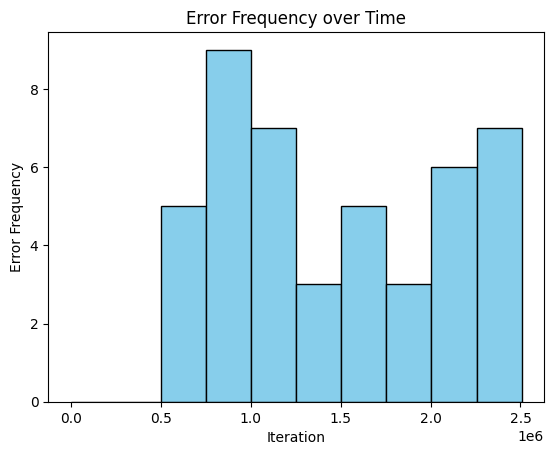

In [7]:
plt.hist(fails.index, color='skyblue', edgecolor='black', range=(0, len(orig)))
plt.xlabel('Iteration')
plt.ylabel('Error Frequency')
plt.title('Error Frequency over Time')
plt.show()

## Errors with respect to iteration

In [8]:
def plot_error_freq_time(data, title, subplot):
    errors = data[(data != 0).any(axis=1)] # Not 0 0 (error)
    subplot.hist(errors.index, range=(0, len(data)), edgecolor='black')
    subplot.set_title(title)
    subplot.set_xlabel('Iteration')
    subplot.set_ylabel('Errors')

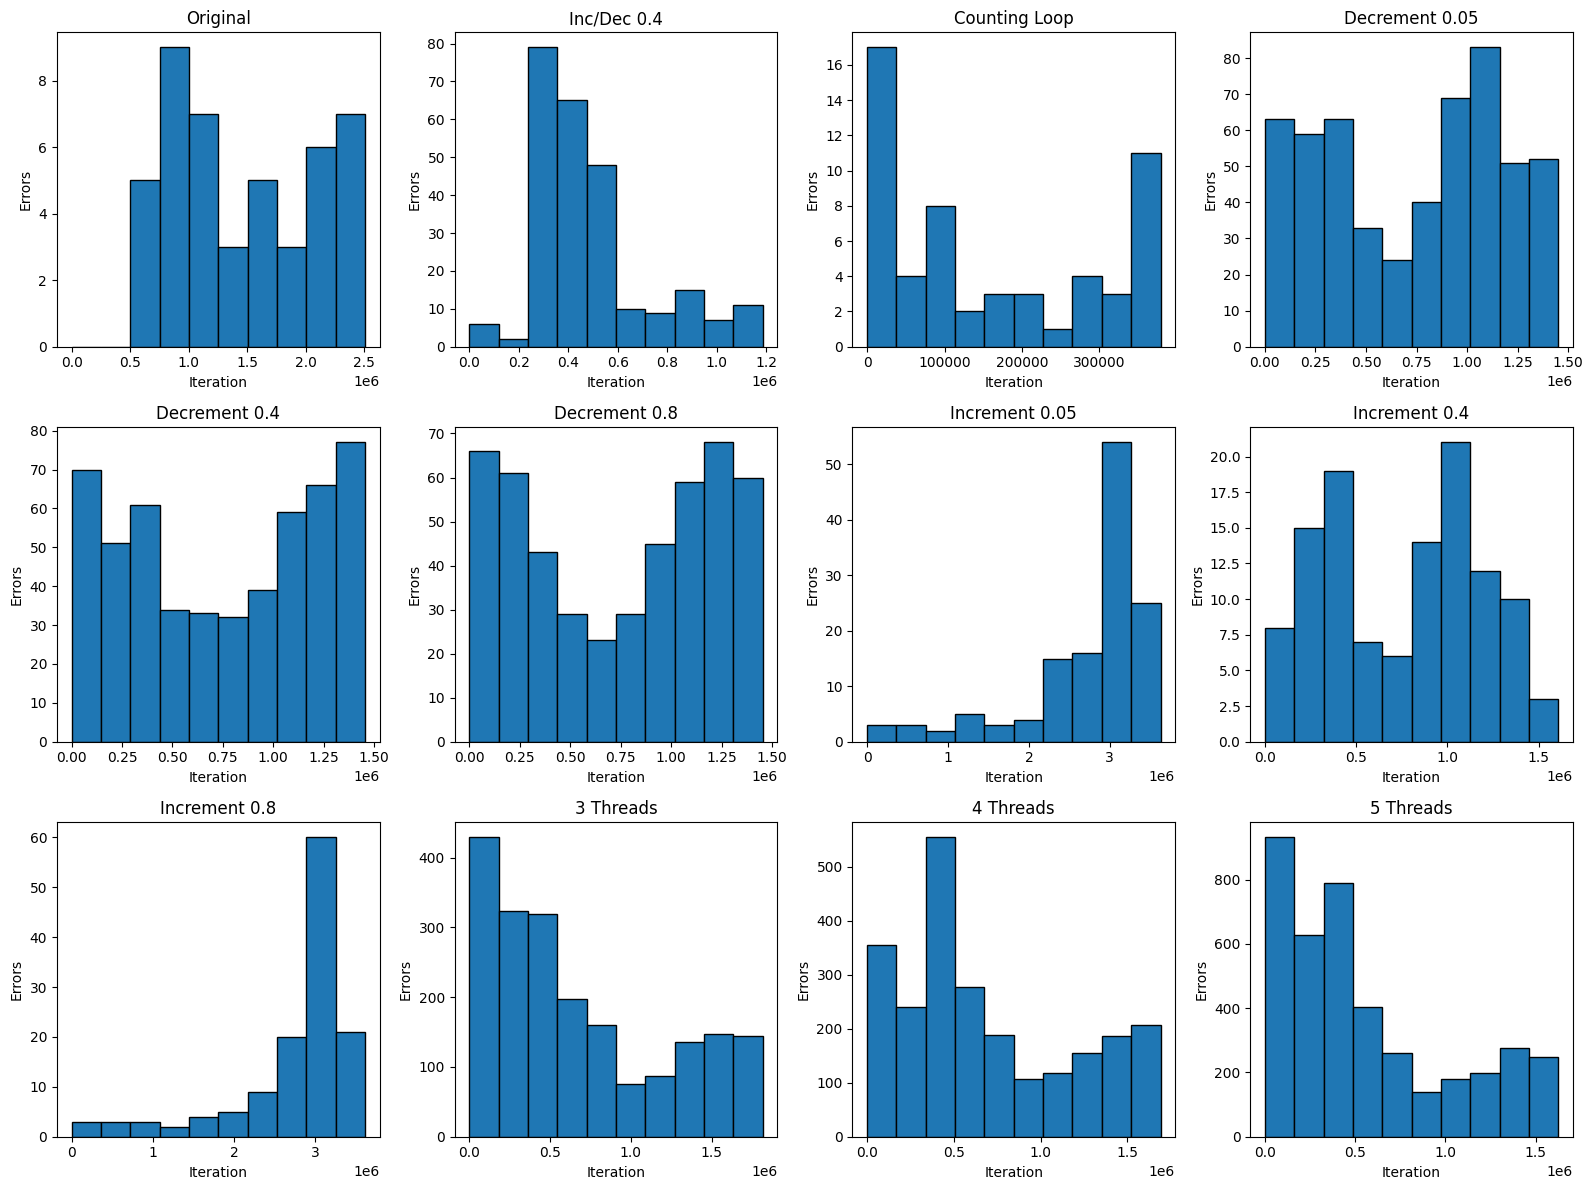

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
axs = axs.flatten()

names = ['Original', 'Inc/Dec 0.4', 'Counting Loop', 'Decrement 0.05', 'Decrement 0.4', 'Decrement 0.8', 'Increment 0.05',
         'Increment 0.4', 'Increment 0.8', '3 Threads', '4 Threads', '5 Threads']
for i in range(12):
    plot_error_freq_time(frames[i], names[i], axs[i])

plt.tight_layout()
plt.show()

There seems to be a bit of a dip in the error quantities at about the midpoint of execution in some cases, though not in all. The distributions seem to be very similar in all cases when the number of samples is almost equal (the varying decrement trials show this well), but when the sample size differs the distributions tend to differ greatly. (Sample size is the max value on the iteration axis.) Maybe another factor such as CPU load is significant in causing differences, but we do not have that data.

## Error rate with respect to varied factors

In [10]:
def error_rate(data, drop=False):
    return len(data[(data != 0).any(axis=1)]) / len(data)

In [11]:
data = {
    'Loop': [False, False, True, False, False, False, False, False, False, False, False, False],
    'IncrementSleep': [0.1, 0.4, 0.1, 0.1, 0.1, 0.1, 0.05, 0.4, 0.8, 0.1, 0.1, 0.1],
    'DecrementSleep': [0.2, 0.4, 0.2, 0.05, 0.4, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
    'Threads': [2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 5],
    'ErrorRate': [error_rate(f) for f in frames],
    'Samples': [len(f) for f in frames]
}

data = pd.DataFrame(data)
data

,Loop,IncrementSleep,DecrementSleep,Threads,ErrorRate,Samples
0,False,0.10,0.20,2,0.000018,2506274
1,False,0.40,0.40,2,0.000212,1186343
2,True,0.10,0.20,2,0.000148,378767
3,False,0.10,0.05,2,0.000370,1450771
4,False,0.10,0.40,2,0.000359,1454576
5,False,0.10,0.80,2,0.000332,1452834
6,False,0.05,0.20,2,0.000036,3626922
7,False,0.40,0.20,2,0.000072,1607400
8,False,0.80,0.20,2,0.000036,3612327
9,False,0.10,0.20,3,0.001113,1815628


### Individual predictors of error rate

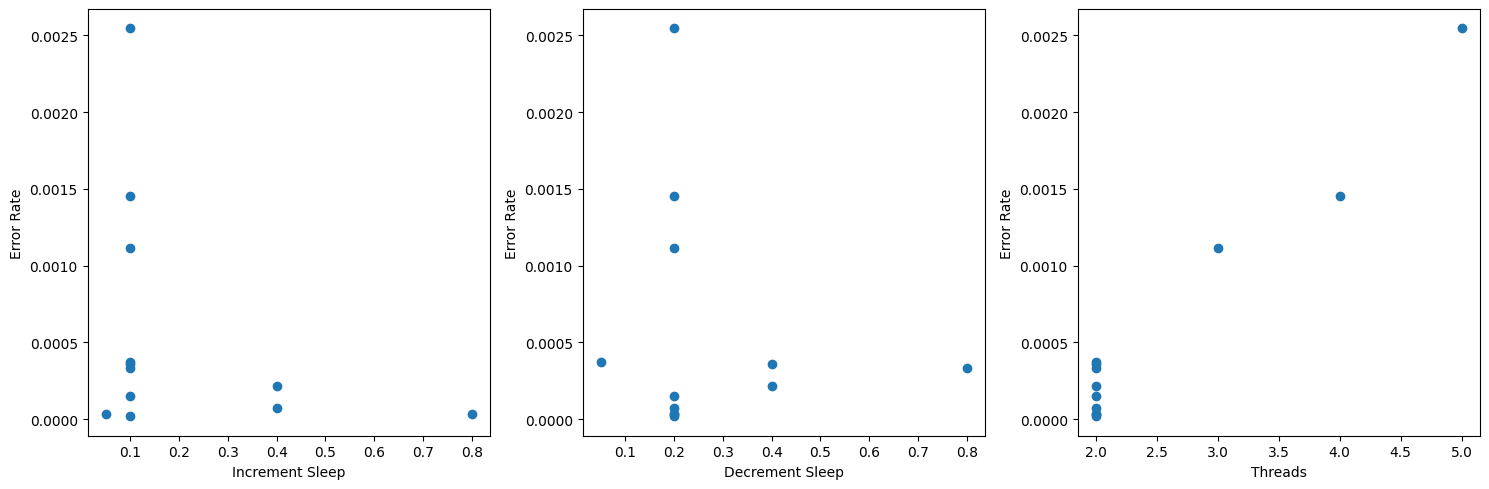

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

axs[0].scatter(data['IncrementSleep'], data['ErrorRate'])
axs[0].set_xlabel('Increment Sleep')
axs[0].set_ylabel('Error Rate')

axs[1].scatter(data['DecrementSleep'], data['ErrorRate'])
axs[1].set_xlabel('Decrement Sleep')
axs[1].set_ylabel('Error Rate')

axs[2].scatter(data['Threads'], data['ErrorRate'])
axs[2].set_xlabel('Threads')
axs[2].set_ylabel('Error Rate')

plt.tight_layout()
plt.show()

Individually, error rate doesn't seem to vary much with respect to increment sleep or decrement sleep (extreme values here correspond to differing thread quantities). However, it seems that as the number of threads increases, so does error rate.

### Aggregated predictors of error rate

In [13]:
lm_fit = ols('ErrorRate ~ IncrementSleep + DecrementSleep + Threads', data=data).fit()
print(lm_fit.params)
print("R^2 value:",lm_fit.rsquared)

Intercept        -0.001350
IncrementSleep   -0.000205
DecrementSleep    0.000244
Threads           0.000754
dtype: float64
R^2 value: 0.9663992679297622


In [14]:
lm_fit_reduced = ols('ErrorRate ~ Threads', data=data).fit()

anova_results = sm.stats.anova_lm(lm_fit_reduced, lm_fit)

anova_results

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,10.0,2.697149e-07,0.0,NaN,NaN,NaN
1,8.0,2.201641e-07,2.0,4.955073e-08,0.900251,0.443983


Testing the hypothesis that the model with just the number of threads predicting error rate is significant, the F-test comparing the full model (containing increment section sleep, decrement section sleep, and number of threads) with the reduced model (only containing number of threads as a predictor) yielded a p-value of 0.444. This indicates that we cannot say at any reasonable significance level that increment section sleep or decrement section sleep are significant in determining error rate.

In [15]:
print(lm_fit_reduced.params)
print("R^2 value:",lm_fit_reduced.rsquared)

Intercept   -0.001331
Threads      0.000756
dtype: float64
R^2 value: 0.9588369970600485


Our final linear model for predicting error rate is $y=0.000756x-0.001331$, where $y$ is the error rate and $x$ is the number of threads. The high $R^2$ value of $0.959$ indicates that our model is effective at predicting error rate.